<font size='6'><b> Plots for the journal paper </b></font>

# Initialize

In [569]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [570]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

os.environ["CUDA_VISIBLE_DEVICES"]=""

import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../gantools/')
sys.path.insert(0, '../../tfnntools//')

from gantools import utils
from gantools import plot
from gantools.gansystem import GANsystem
from gantools.data import Dataset, Dataset_parameters
from gantools.data import transformation

from cosmotools.model import CosmoWGAN
from cosmotools.metric import evaluation
from cosmotools.data import load
from cosmotools.utils import histogram_large, write_pickle, read_pickle, printt

from gantools.model import ConditionalParamWGAN
from gantools.gansystem import GANsystem

# Parameters

In [571]:
ns = 128 # Resolution of the image
try_resume = True # Try to resume previous simulation

def non_lin(x):
    return tf.nn.relu(x)

# Data handling

In [572]:
dataset_train_shuffled_name = 'kids_train_shuffled.h5'
dataset_train_name = 'kids_train.h5'
dataset_test_name = 'kids_test.h5'

# Define parameters for the WGAN

In [573]:
time_str = '2D'
global_path = '../../../upscaleGAN/saved_results'
name = 'KidsConditional{}'.format(ns) + '_smart_' + time_str

## Parameters

In [574]:
bn = False

params_discriminator = dict()
params_discriminator['stride'] = [1, 2, 2, 2, 2]
params_discriminator['nfilter'] = [32, 64, 128, 256, 512]
params_discriminator['shape'] = [[7, 7], [5, 5], [5, 5], [5,5], [3,3]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn, bn]
params_discriminator['full'] = [512, 256, 128]
params_discriminator['minibatch_reg'] = False
params_discriminator['summary'] = True
params_discriminator['data_size'] = 2

params_generator = dict()
params_generator['stride'] = [2, 2, 2, 2, 1]
params_generator['latent_dim'] = 64
params_generator['nfilter'] = [256, 128, 64, 32, 1]
params_generator['shape'] = [[3, 3], [5, 5], [5, 5], [5, 5], [7,7]]
params_generator['batch_norm'] = [bn, bn, bn, bn]
params_generator['full'] = [256, 512, 8 * 8 * 512]
params_generator['summary'] = True
params_generator['non_lin'] = non_lin
params_generator['data_size'] = 2

params_optimization = dict()
params_optimization['optimizer'] = 'rmsprop'
params_optimization['batch_size'] = 64
params_optimization['learning_rate'] = 1e-5
params_optimization['epoch'] = 10

# all parameters
params = dict()
params['net'] = dict() # All the parameters for the model
params['net']['generator'] = params_generator
params['net']['discriminator'] = params_discriminator
params['net']['shape'] = [ns, ns, 1] # Shape of the image
params['net']['gamma_gp'] = 10 # Gradient penalty

# Conditional params
params['net']['prior_normalization'] = False
params['net']['cond_params'] = 2
params['net']['init_range'] = [[0.101, 0.487], [0.487, 1.331]]
params['net']['prior_distribution'] = "gaussian_length"
params['net']['final_range'] = [0.1*np.sqrt(params_generator['latent_dim']), 1*np.sqrt(params_generator['latent_dim'])]

params['optimization'] = params_optimization
params['optimization']['discriminator'] = deepcopy(params_optimization)
params['optimization']['generator'] = deepcopy(params_optimization)
params['summary_every'] = 5000 # Tensorboard summaries every ** iterations
params['print_every'] = 2500 # Console summaries every ** iterations
params['save_every'] = 25000 # Save the model every ** iterations
params['duality_every'] = 5
params['summary_dir'] = os.path.join(global_path, name +'_summary/')
params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')
params['Nstats'] = 2000

In [575]:
resume, params = utils.test_resume(try_resume, params)
# If a model is reloaded and some parameters have to be changed, then it should be done here.
# For example, setting the number of epoch to 5 would be:
# params['optimization']['epoch'] = 5
params['summary_dir'] = os.path.join(global_path, name +'_summary/')
params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')

No resume, the training will start from the beginning!


## Build the model

In [576]:
class CosmoConditionalParamWGAN(ConditionalParamWGAN, CosmoWGAN):
    pass

In [577]:
wgan = GANsystem(CosmoConditionalParamWGAN, params)

Generator 
--------------------------------------------------
     The input is of size (?, 128)
     0 Full layer with 256 outputs
         Size of the variables: (?, 256)
     1 Full layer with 512 outputs
         Size of the variables: (?, 512)
     2 Full layer with 32768 outputs
         Size of the variables: (?, 32768)
     Reshape to (?, 8, 8, 512)
     3 Deconv layer with 256 channels
         Non linearity applied
         Size of the variables: (?, 16, 16, 256)
     4 Deconv layer with 128 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 128)
     5 Deconv layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 64, 64, 64)
     6 Deconv layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 128, 128, 32)
     7 Deconv layer with 1 channels
         Size of the variables: (?, 128, 128, 1)
    Costum non linearity: <function non_lin at 0x7fd2f9cc80d0>
     The output is of 

## Train the model

In [578]:
# wgan.train(dataset, resume=resume)

In [579]:
checkpoint = 349163

# FIGURE n-body vs GAN

In [151]:
# Compare real and fake
grid = np.array([[0.137, 1.23], [0.199, 0.87], [0.311, 0.842], [0.487, 0.643]])

In [152]:
dataset = load.load_params_dataset(filename=dataset_test_name, batch=10, sorted=True, shape=[ns, ns])

In [153]:
# Produce images
latent = wgan.net.sample_latent(bs=len(grid), params=grid)
gen_images = wgan.generate(N=len(grid), **{'z': latent}, checkpoint=checkpoint)

# Get real images
real_images = []
for p in grid:
    real_images.append(dataset.get_data_for_params(p, N=10)[0])

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!


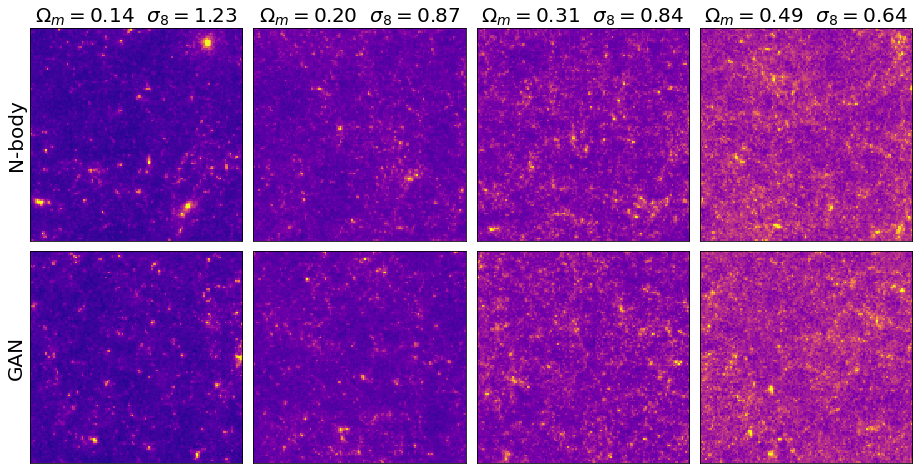

In [149]:
nrows, ncols=2, 4
fontsize_title=20
fontsize_label=20
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
idx = 0
kwargs_imshow = {'interpolation':'none'}
for i in range(ncols):
        plot.plot_img(real_images[i][np.random.randint(10)], vmin=vmin, vmax=vmax, ax=ax[0,i], kwargs_imshow=kwargs_imshow)
        plot.plot_img(gen_images[i], vmin=vmin, vmax=vmax, ax=ax[1,i], kwargs_imshow=kwargs_imshow)
for i in range(ncols):
    title_str = r'$\Omega_m={:2.2f} \ \ \sigma_8={:2.2f}$'.format(grid[i][0], grid[i][1])
    ax[0,i].set_title(title_str, fontsize=fontsize_title)
ax[0,0].set_ylabel('N-body', fontsize=fontsize_label)
ax[1,0].set_ylabel('GAN', fontsize=fontsize_label)
fig.subplots_adjust(hspace=0.05, wspace=0.0)
fig.savefig('figure_maps_nbody_vs_gan.pdf', bbox_inches='tight', dpi=200)

# FIGURE latent interpolation

In [2979]:
inter = 3

In [2981]:
# Generate grid
grid = []
for c in range(wgan.net.params['cond_params']):
    if c == 0:
        gen_params = np.linspace(0.2, 0.4, inter)
    if c == 1:
        gen_params = np.linspace(0.70, 0.9, inter)
    grid.append(gen_params)

# Note: assume 2D grid of parameters
gen_params = []
for i in range(inter):
    for j in range(inter):
        gen_params.append([grid[0][i], grid[1][j]])
gen_params = np.array(gen_params)

imgs = evaluation.generate_samples_same_seed(wgan, gen_params, checkpoint=checkpoint)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
C

In [2995]:
dict_latent_interp = dict(imgs=imgs, gen_params=gen_params)
write_pickle('latent_interpolation_images.pkl', dict_latent_interp)

wrote latent_interpolation_images.pkl


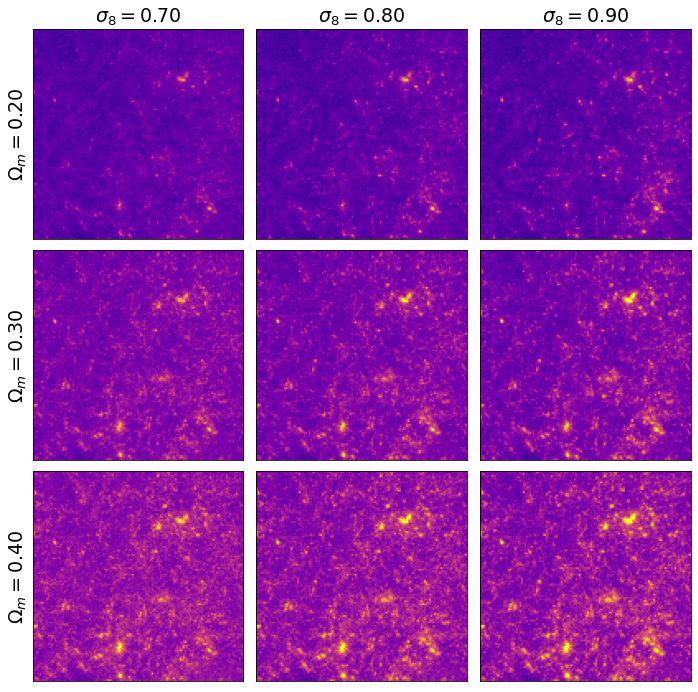

In [2996]:
fig, ax = plt.subplots(nrows=inter, ncols=inter, figsize=(inter*4,inter*4), gridspec_kw={'hspace':0.05, 'wspace':0.01})
idx = 0

for i in range(inter):
    for j in range(inter):
        plot.plot_img(imgs[idx][0], vmin=0.01, vmax=0.12, ax=ax[i,j])
        if i==0:
            title_str = r'$\sigma_8={:2.2f}$'.format(gen_params[idx][1])
            ax[i,j].set_title(title_str, fontsize=fontsize_title)
        if j==0:
            title_str = r'$\Omega_m={:2.2f}$'.format(gen_params[idx][0])
            ax[i,j].set_ylabel(title_str, fontsize=fontsize_title)
        
        idx = idx + 1
fig.savefig('figure_latent_interpolation.pdf', dpi=200, bbox_inches='tight')

# Calculate summary statistics (produces pickled results)

In [455]:
N = 1000

## Calculate stats for the training set

In [456]:
dataset = load.load_params_dataset(filename=dataset_train_name, batch=N, sorted=True, shape=[ns, ns])

In [457]:
params = dataset.get_different_params()
params_train = params

In [458]:
# Define getter functions for every parameter set
# Note this is needed to save memory, as in this way every subset is loaded only when needed
real_imgs = []
fake_imgs = []
for p in params:
    real_imgs.append(lambda p1=p: dataset.get_data_for_params(p1, N=N)[0])
    fake_imgs.append(lambda p1=p: evaluation.generate_samples_params(wgan, p1, nsamples=N, checkpoint=checkpoint))

In [459]:
# Parameters used for plotting
lenstools = True
def title_func(params):
    return "$\Omega_M$: " + str(params[0])[0:7] + ", $\sigma_8$: " + str(params[1])[0:7]

ylims = [[(1e-7, 1e-3), (0, 0.5)], 
         [(1e-2, 1e3), (0, 0.5)], 
         [(1e-2, 1e5), (0, 0.5)],
         [(1e-7, 1e-3), (0, 0.5)],
         [(1e-7, 1e-3), (0, 0.5)],
         [(1e-7, 1e-3), (0, 0.5)]]
    
fractional_difference = [True]*6

box_l = (5*np.pi/180)
bin_k = 200
cut = [200, 6000]
cut_corr = [0, 6000]
thresholds_minkowski = np.linspace(0.01, 0.1, 100)

In [ ]:
fig, score_train, list_plotdata_stats  = evaluation.compute_plots_for_params(params, real_imgs, fake_imgs, param_str=title_func, ylims=ylims, log=False, confidence='std', lim=(0, 0.4), fractional_difference=fractional_difference, cut=cut, lenstools=lenstools, box_l=box_l, bin_k=bin_k, thresholds_minkowski=thresholds_minkowski)
write_pickle('compute_plots_for_params__trainset.pkl', list_plotdata_stats)


In [ ]:
# Save scores for heatmap
train_params = params

Calculate 1D distribution tests

In [591]:
dataset = load.load_params_dataset(filename=dataset_train_name, batch=N, sorted=True, shape=[ns, ns])
params_train = dataset.get_different_params()
real_imgs = []
fake_imgs = []
for p in params_train:
    real_imgs.append(lambda p1=p: dataset.get_data_for_params(p1, N=N)[0])
    fake_imgs.append(lambda p1=p: evaluation.generate_samples_params(wgan, p1, nsamples=N, checkpoint=checkpoint))

In [592]:
wass_pixel, wass_peaks = evaluation.get_1D_sample_tests(params_train, real_imgs, fake_imgs)
do = dict(wass_pixel=wass_pixel, wass_peaks=wass_peaks, params=params_test)
write_pickle('mass_1D_tests__trainset.pkl', do)


computing Wasserstein-1 for param 0/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
(1000, 128, 128) (1000, 128, 128) 1000
computing Wasserstein-1 for param 1/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
(1000, 128, 128) (1000, 128, 128) 1000
computing Wasserstein-1 for param 2/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
(1000, 128, 128) (1000, 128, 128) 1000
computing Wasserstein-1 for param 3/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsCondi

computing Wasserstein-1 for param 29/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
(1000, 128, 128) (1000, 128, 128) 1000
computing Wasserstein-1 for param 30/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
(1000, 128, 128) (1000, 128, 128) 1000
computing Wasserstein-1 for param 31/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
(1000, 128, 128) (1000, 128, 128) 1000
computing Wasserstein-1 for param 32/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsC

## Calculate stats on the test set

In [143]:
dataset = load.load_params_dataset(filename=dataset_test_name, batch=N, sorted=True, shape=[ns, ns])

Interpolations

In [144]:
params_inter = [[0.137, 1.23],
                [0.25, 0.658],
                [0.311, 0.842],
                [0.199, 0.87],
                [0.254, 0.852],
                [0.312, 0.664],
                [0.356, 0.614],
                [0.421, 0.628]]


params_inter = np.array(params_inter)

In [164]:
# Define getter functions for every parameter set
# Note this is needed to save memory, as in this way every subset is loaded only when needed
real_imgs = []
fake_imgs = []
for p in params_inter:
    real_imgs.append(lambda p1=p: dataset.get_data_for_params(p1, N=N)[0])
    fake_imgs.append(lambda p1=p: evaluation.generate_samples_params(wgan, p1, nsamples=N, checkpoint=checkpoint))

In [165]:
fig, score_inter, list_plotdata_stats = evaluation.compute_plots_for_params(params_inter, real_imgs, fake_imgs, param_str=title_func, ylims=ylims, log=False, confidence='std', lim=(0, 0.4), fractional_difference=fractional_difference, lenstools=lenstools, cut=cut, box_l=box_l, bin_k=bin_k, thresholds_minkowski=thresholds_minkowski)
plt.close(fig)
write_pickle('compute_plots_for_params__interpolation.pkl', list_plotdata_stats)


computing plots for param 0/8 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing plots for param 1/8 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing plots for param 2/8 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing plots for param 3/8 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing plots for param 4/8 [*] Reading checkpoints...
INF

In [166]:
write_pickle('compute_plots_for_params__interpolation.pkl', list_plotdata_stats)

wrote compute_plots_for_params__interpolation.pkl


Extrapolations

In [145]:
params_extra = [[0.196, 1.225],
                [0.127, 0.836],
                [0.487, 0.643]]
params_extra = np.array(params_extra)

In [146]:
# Define getter functions for every parameter set
# Note this is needed to save memory, as in this way every subset is loaded only when needed
real_imgs = []
fake_imgs = []
for p in params_extra:
    real_imgs.append(lambda p1=p: dataset.get_data_for_params(p1, N=N)[0])
    fake_imgs.append(lambda p1=p: evaluation.generate_samples_params(wgan, p1, nsamples=N, checkpoint=checkpoint))

In [169]:
fig, score_extra, list_plotdata_stats = evaluation.compute_plots_for_params(params_extra, real_imgs, fake_imgs, param_str=title_func, ylims=ylims, log=False, confidence='std', lim=(0, 0.4), fractional_difference=fractional_difference, lenstools=lenstools, cut=cut, box_l=box_l, bin_k=bin_k, thresholds_minkowski=thresholds_minkowski)
plt.close(fig)
write_pickle('compute_plots_for_params__extrapolation.pkl', list_plotdata_stats)


computing plots for param 0/3 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing plots for param 1/3 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing plots for param 2/3 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
wrote compute_plots_for_params__extrapolation.pkl


Calculate 1D distribution tests

In [593]:
dataset = load.load_params_dataset(filename=dataset_test_name, batch=N, sorted=True, shape=[ns, ns])
params_test = dataset.get_different_params()
real_imgs = []
fake_imgs = []
for p in params_test:
    real_imgs.append(lambda p1=p: dataset.get_data_for_params(p1, N=N)[0])
    fake_imgs.append(lambda p1=p: evaluation.generate_samples_params(wgan, p1, nsamples=N, checkpoint=checkpoint))

In [594]:
wass_pixel, wass_peaks = evaluation.get_1D_sample_tests(params_test, real_imgs, fake_imgs)
do = dict(wass_pixel=wass_pixel, wass_peaks=wass_peaks, params=params_test)
write_pickle('mass_1D_tests__testset.pkl', do)


computing Wasserstein-1 for param 0/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
(1000, 128, 128) (1000, 128, 128) 1000
computing Wasserstein-1 for param 1/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
(1000, 128, 128) (1000, 128, 128) 1000
computing Wasserstein-1 for param 2/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
(1000, 128, 128) (1000, 128, 128) 1000
computing Wasserstein-1 for param 3/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsCondi

## MS-SSIM structural similarity index

In [170]:
def get_ssim_for_dataset(dataset_name, N=2000):
    dataset = load.load_params_dataset(filename=dataset_name, batch=N, sorted=True, shape=[ns, ns])
    real_imgs = []
    fake_imgs = []
    for p in dataset.get_different_params():
        real_imgs.append(lambda p1=p: dataset.get_data_for_params(p1, N=N)[0])
        fake_imgs.append(lambda p1=p: evaluation.generate_samples_params(wgan, p1, nsamples=N, checkpoint=checkpoint))
    s_fake_all, s_real_all = evaluation.compute_ssim_score(fake_imgs, real_imgs)
    dict_ssim = dict(s_fake_all=s_fake_all, s_real_all=s_real_all, params_cosmo=dataset.get_different_params())
    return dict_ssim


In [171]:
dict_ssim_trainset = get_ssim_for_dataset(dataset_train_name, N=N)
write_pickle('dict_ssim_trainset.pkl', dict_ssim_trainset)
dict_ssim_testset = get_ssim_for_dataset(dataset_test_name, N=N)
write_pickle('dict_ssim_testset.pkl', dict_ssim_testset)

computing ssim 0/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing ssim 1/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing ssim 2/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing ssim 3/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing ssim 4/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../up

Checkpoint succesfully loaded!
computing ssim 37/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing ssim 38/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing ssim 39/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing ssim 40/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
computing ssim 41/46 [*] Reading checkpoints...
INFO:tensorflow:R

## Correlation matrix analysis

In [119]:
from cosmotools.metric import stats

In [121]:
def get_correlation_matrices_for_dataset(dataset_name, N=2000):
    
    dataset = load.load_params_dataset(filename=dataset_name, batch=N, sorted=True, shape=[ns, ns])
    params_cosmo = dataset.get_different_params()
    dict_res = {'covmat_real':[], 'covmat_fake':[],'corrmat_real':[], 'corrmat_fake':[]}
    for i, p in enumerate(params_cosmo):
        printt('param {}/{} {}'.format(i, len(params_cosmo), dataset_name))
        real_imgs = dataset.get_data_for_params(p, N)[0]
        fake_imgs = evaluation.generate_samples_params(wgan, p, nsamples=N, checkpoint=checkpoint)
        corrmat_real, covmat_real, _ = stats.psd_correlation_lenstools(real_imgs, cut=cut_corr, box_l=box_l, bin_k=bin_k)
        corrmat_fake, covmat_fake, _ = stats.psd_correlation_lenstools(fake_imgs, cut=cut_corr, box_l=box_l, bin_k=bin_k)
        dict_res['corrmat_real'] += [corrmat_real]
        dict_res['corrmat_fake'] += [corrmat_fake]
        dict_res['covmat_real'] += [covmat_real]
        dict_res['covmat_fake'] += [covmat_fake]

    return dict_res

In [120]:
N = 5000
cut_corr = [300,300
bin_k = 20

In [122]:
c_test = get_correlation_matrices_for_dataset(dataset_name=dataset_test_name, N=N)
c_train = get_correlation_matrices_for_dataset(dataset_name=dataset_train_name, N=N)
dict_out = dict(c_train=c_train, c_test=c_test, cut_corr=cut_corr, bin_k=bin_k)
write_pickle('corr_results.pkl', dict_out)

param 0/11 kids_test.h5 [*] Reading checkpoints...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 1/11 kids_test.h5 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 2/11 kids_test.h5 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 3/11 kids_test.h5 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loade

param 23/46 kids_train.h5 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 24/46 kids_train.h5 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 25/46 kids_train.h5 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 26/46 kids_train.h5 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 27/46 kids_train.h5 [*] Reading checkpoints...
INFO:tensorflow:Restori

## Frechet Inception Distance

In [116]:
def get_frechet_results_for_dataset(dataset_name, N=2000):
    dataset = load.load_params_dataset(filename=dataset_name, batch=N, sorted=True, shape=[ns, ns])
        # Define parameters
    params = dataset.get_different_params()
    params = np.array(params)
    # Generate images
    real_imgs = []
    fake_imgs = []
    for i, p in enumerate(params):
        printt('param {}/{}'.format(i, len(params)))
        real_imgs.append(dataset.get_data_for_params(p, N=N)[0])
        fake_imgs.append(evaluation.generate_samples_params(wgan, p, nsamples=N, checkpoint=checkpoint))

    fids, fig, pred_params, params, features = evaluation.compute_plot_fid(real_imgs, fake_imgs, params, regressor_path, batch_size=N, checkpoint=140000, lims=[[0.05, 0.5], [0.4, 1.4]], alpha=0.025)
    plt.close(fig)
    dict_pickle = dict(fids=fids, pred_params=pred_params, params=params, features=features)
    return dict_pickle

In [117]:
# Load regressor
regressor_path = '../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/'
N = 500

In [103]:
wgan = GANsystem(CosmoConditionalParamWGAN, params)
dict_pickle_test = get_frechet_results_for_dataset(dataset_name=dataset_test_name, N=N)
wgan = GANsystem(CosmoConditionalParamWGAN, params)
dict_pickle_train = get_frechet_results_for_dataset(dataset_name=dataset_train_name, N=N)
dict_pickle_full = dict(dict_pickle_train=dict_pickle_train, dict_pickle_test=dict_pickle_test, N=N)
write_pickle('results_fid.pkl', dict_pickle_full)

Generator 
--------------------------------------------------
     The input is of size (?, 128)
     0 Full layer with 256 outputs
         Size of the variables: (?, 256)
     1 Full layer with 512 outputs
         Size of the variables: (?, 512)
     2 Full layer with 32768 outputs
         Size of the variables: (?, 32768)
     Reshape to (?, 8, 8, 512)
     3 Deconv layer with 256 channels
         Non linearity applied
         Size of the variables: (?, 16, 16, 256)
     4 Deconv layer with 128 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 128)
     5 Deconv layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 64, 64, 64)
     6 Deconv layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 128, 128, 32)
     7 Deconv layer with 1 channels
         Size of the variables: (?, 128, 128, 1)
    Costum non linearity: <function non_lin at 0x7fd329f30f28>
     The output is of 

INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 1/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 2/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 3/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 4/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_W

Model loaded.
params 9/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
params 10/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
computing FIDGenerator 
--------------------------------------------------
     The input is of size (?, 128)
     0 Full layer with 256 outputs
         Size of the variables: (?, 256)
     1 Full layer wit

param 0/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 1/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 2/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 3/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 4/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_sma

Checkpoint succesfully loaded!
param 38/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 39/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 40/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 41/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 42/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/

Model loaded.
params 11/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
params 12/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
params 13/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] 

params 32/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
params 33/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
params 34/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkp

# Define statistics parameters

In [622]:
from collections import OrderedDict
list_stat_all = ['psd', 'peak_count', 'mass_hist', 'bispectrum', 'minkowski_V0', 'minkowski_V1', 'minkowski_V2', 'ssim_sig', 'corr_fro_norm', 'corr_diff', 'fid', 'wasserstein_mass_hist']
stat_specs = {s:{'cmap':plt.cm.viridis} for s in list_stat_all}

stat_specs['psd']['name_math'] = r'$C_\ell$'
stat_specs['psd']['ylabel'] = r'$C_\ell \cdot \ell \cdot (\ell+1) \ /  \ (2\pi)$'
stat_specs['psd']['xlabel'] = r'$\ell$'
stat_specs['psd']['xlim'] = [300,3000] 
stat_specs['psd']['ylim'] = [0, 5e-5]
stat_specs['psd']['yscale'] = 'linear'
stat_specs['psd']['margin_left'] = 0.2
stat_specs['psd']['difference_range'] = [0, 0.05]
stat_specs['psd']['difference_title'] = 'fractional difference\n'+r'power spectrum $C_\ell$'


stat_specs['peak_count']['name_math'] = r'$N_{\rm{peaks}}$'
stat_specs['peak_count']['ylabel'] = r'$N_{\rm{peaks}}$'
stat_specs['peak_count']['xlabel'] = r'$\kappa$'
stat_specs['peak_count']['xlim'] = [0.025, 0.09] 
stat_specs['peak_count']['ylim'] = [0, 1e2]
stat_specs['peak_count']['yscale'] = 'linear'

stat_specs['mass_hist']['name_math'] = r'$N_{\rm{pixels}}$'
stat_specs['mass_hist']['ylabel'] = r'$N_{\rm{pixels}}$'
stat_specs['mass_hist']['xlabel'] = r'$\kappa$'
stat_specs['mass_hist']['xlim'] = [0.02, 0.08] 
stat_specs['mass_hist']['ylim'] = [0, 3e3]
stat_specs['mass_hist']['yscale'] = 'linear'
stat_specs['mass_hist']['difference_range'] = [0, 0.05]
stat_specs['mass_hist']['difference_title'] = 'fractional difference\n'+r'power spectrum $N_{pix}$'

stat_specs['minkowski_V0']['name_math'] = r'V_0'
stat_specs['minkowski_V0']['ylabel'] = r'Minkowski $V_0$'
stat_specs['minkowski_V0']['xlabel'] = r'$\kappa$'
stat_specs['minkowski_V0']['xlim'] = [0.02, 0.08] 
stat_specs['minkowski_V0']['ylim'] = [0, 1.05]
stat_specs['minkowski_V0']['yscale'] = 'linear'

stat_specs['minkowski_V1']['name_math'] = r'V_1'
stat_specs['minkowski_V1']['ylabel'] = r'Minkowski $V_1$'
stat_specs['minkowski_V1']['xlabel'] = r'$\kappa$'
stat_specs['minkowski_V1']['xlim'] = [0.02, 0.08] 
stat_specs['minkowski_V1']['ylim'] = [0, 0.1]
stat_specs['minkowski_V1']['yscale'] = 'linear'

stat_specs['minkowski_V2']['name_math'] = r'V_2'
stat_specs['minkowski_V2']['ylabel'] = r'Minkowski $V_2$'
stat_specs['minkowski_V2']['xlabel'] = r'$\kappa$'
stat_specs['minkowski_V2']['xlim'] = [0.02, 0.08]  
stat_specs['minkowski_V2']['ylim'] = [-0.02, 0.012]
stat_specs['minkowski_V2']['yscale'] = 'linear'

stat_specs['bispectrum']['name_math'] = r'$B_{\ell}$'
stat_specs['bispectrum']['ylabel'] = r'$B_{\ell} \cdot \ell \cdot (\ell+1) \cdot (\ell+2) \ /  \ (2\pi)$'
stat_specs['bispectrum']['xlabel'] = r'$\ell$'
stat_specs['bispectrum']['xlim'] = [300, 3000]  
stat_specs['bispectrum']['ylim'] = [0., 2e-8]
stat_specs['bispectrum']['yscale'] = 'linear'
stat_specs['bispectrum']['difference_range'] = [0, 0.2]
stat_specs['bispectrum']['difference_title'] = 'fractional difference\n'+r'bispectrum $B_\ell$'

stat_specs['ssim_sig']['name_math'] = r'$\sigma [\rm{SSIM}]$'
stat_specs['ssim_sig']['difference_range'] = [-1, 1]
stat_specs['ssim_sig']['difference_title'] = 'difference significance\n'+r'Structural Similarity Index SSIM'
stat_specs['ssim_sig']['cmap'] = plt.cm.Spectral_r

stat_specs['corr_fro_norm']['name_math'] = r'fro norm'
stat_specs['corr_fro_norm']['difference_range'] = [0,0.5]
stat_specs['corr_fro_norm']['difference_title'] = 'fractional difference\n'+r'correlation matrix $R_{\ell\ell^\prime}$'
stat_specs['corr_fro_norm']['cmap'] = plt.cm.viridis

stat_specs['corr_diff']['name_math']  = 'diff'
stat_specs['corr_diff']['difference_range']  = [0,0.08]
stat_specs['corr_diff']['difference_title']  = r'fractional difference $\rm{Corr}$'

stat_specs['fid']['name_math']  = 'FID'
stat_specs['fid']['difference_range']  = [0,3]
stat_specs['fid']['difference_title']  = 'Fréchet ' + 'Distance FID$^{1/2}$' + '\non CNN regressor output'
stat_specs['fid']['cmap'] = plt.cm.viridis

stat_specs['wasserstein_mass_hist']['name_math']  = 'Wasserstein1D'
stat_specs['wasserstein_mass_hist']['difference_range']  = [0,5e-2]
stat_specs['wasserstein_mass_hist']['difference_title']  = 'normalised Wasserstein-1 distance\npixel values'
stat_specs['wasserstein_mass_hist']['cmap'] = plt.cm.viridis


# FIGURE statistics for interpolated cosmologies

In [130]:
def get_title_str(par):
    return r'$\Omega_m={:2.2f} \quad \sigma_8={:2.2f}$'.format(par[0], par[1])

In [131]:
def get_frac_diff(y1, y2):
    f = (y1-y2)/y1
    return f

def get_dynamic_range_difference(y1, y2):
    ym = (y1+y2)/2.
    return (y1-y2)/np.abs(np.max(ym)-np.min(ym))

def get_dynamic_range_difference2(y1, y2):
    ym = (y1+y2)/2.
    return 2*(y1-y2)/(y2+(np.max(ym)-np.min(ym)))

In [132]:
def plot_single_statistic_with_ratio(ax, x, y_real, y_gen):
    
    
    qs=[32, 50, 68]
    ypr = np.percentile(y_real, q=qs, axis=0)
    ypg = np.percentile(y_gen, q=qs, axis=0)
    fd = get_frac_diff(ypg[1], ypr[1])
#     fd = get_dynamic_range_difference2(ypg[1], ypr[1])
    ax[0].plot(x, ypr[1], color=color_real, label='N-body')
    ax[0].fill_between(x, ypr[0], ypr[2], alpha=alpha, color=color_real)
    ax[0].plot(x, ypg[1], color=color_gen, label='GAN')
    ax[0].fill_between(x, ypg[0], ypg[2], alpha=alpha, color=color_gen)   
    ax[1].plot(x, fd, color=color_ratio)
    ax[1].set(ylim=ylim_ratio, yticks=yticks_ratio)
    ax[1].fill_between(x, -0.05, 0.05, color='gray', alpha=0.1)
    
    for a in ax.ravel(): a.grid(True)


In [133]:
def plot_multiple_statistic_with_ratio(ids, stats, stats_name, show_legend=False):
    
    nx, ny = 2, len(ids); 
    fig, ax = plt.subplots(nx, ny, figsize=(ny * 6, nx * 2.5), squeeze=False, sharex=True, gridspec_kw={'hspace':0.0, 'wspace':0.15, 'height_ratios': [3,1]}); 
        
    spec=stat_specs[stats_name]
    spec.setdefault('margin_left', 0.1)
    
    yr, yg = 'y_real', 'y_fake'
    
    for i, j in enumerate(ids):
        stat = stats[j]
            
        plot_single_statistic_with_ratio(ax=ax[:,i], x=stat[stats_name]['x'], y_real=stat[stats_name][yr], y_gen=stat[stats_name][yg])
        ax[0,i].set_yscale(spec['yscale'])
        if i>0:
            for a in ax[:,i]: a.set_yticklabels([])
                
        ax[1,i].set_xlabel(spec['xlabel'], fontsize=fontsize_ylabel)
        ax[0,i].set_title(get_title_str(params_inter[j]), fontsize=fontsize_title)
        ax[0,i].set_xlim(spec['xlim'])
        ax[0,i].set_ylim(spec['ylim'])
        for a in ax[:,i]:
            a.tick_params(axis='both', labelsize=fontsize_ticks)
        pos_x = spec['xlim'][0] + (spec['xlim'][1]-spec['xlim'][0])*0.1
        pos_y = spec['ylim'][0] + (spec['ylim'][1]-spec['ylim'][0])*0.85
        ax[0,i].scatter(pos_x, pos_y, marker='D', s=markersize_testset*2, c=color_testset, edgecolor='k', zorder=200)
        ax[0,i].text(pos_x, pos_y, params_highlight_labels[i], zorder=201, fontsize=16, ha='center', va='center', color='k')


    ax[0,0].get_yaxis().get_major_formatter().set_useMathText(True)
    ax[0,0].get_yaxis().get_major_formatter().set_powerlimits((0, 0))    
    ax[0,0].set_ylabel(spec['ylabel'], fontsize=fontsize_ylabel)
    if show_legend:
        ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.72, 1), shadow=False, ncol=1, fontsize=fontsize_legend)

    return fig
        
       


In [134]:
stats_interpolation = read_pickle('compute_plots_for_params__interpolation.pkl')
param_ids = [1, 5, 4, 2]
# param_ids = range(7)
n_par = len(param_ids)
alpha = 0.1
color_real = 'b'
color_gen = 'r'
color_ratio = 'k'
fontsize_title=18
fontsize_ylabel=20
fontsize_ticks=14
yticks_ratio = [-0.1, 0, 0.1]
ylim_ratio = [-0.2, 0.2]
color_testset='pink'
color_trainset='c'
markersize_testset=250
markersize_trainset=150
fontsize_legend=20
params_highlight_labels = ['A', 'B', 'C', 'D']


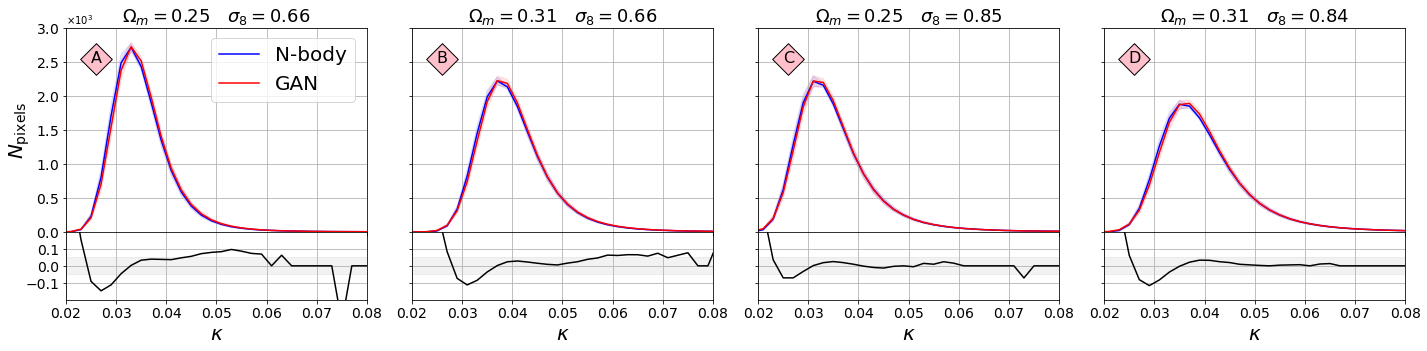

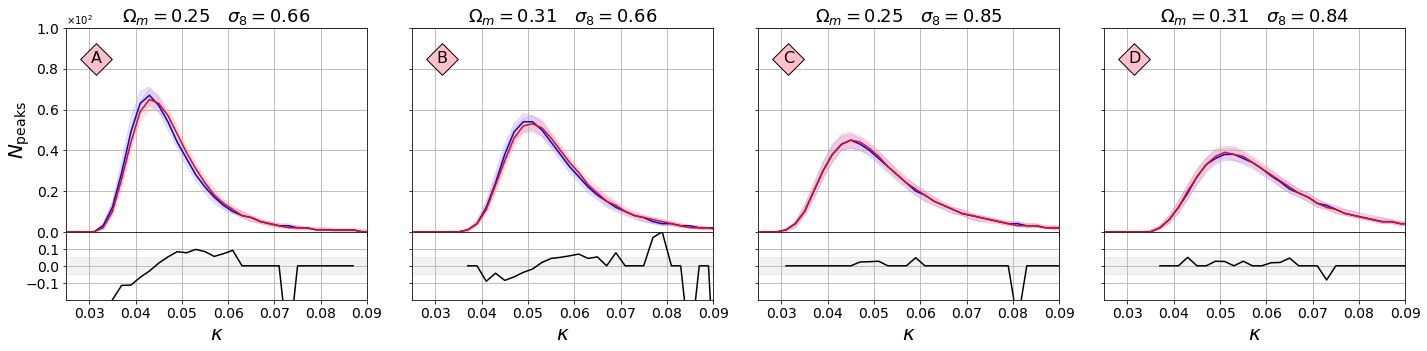

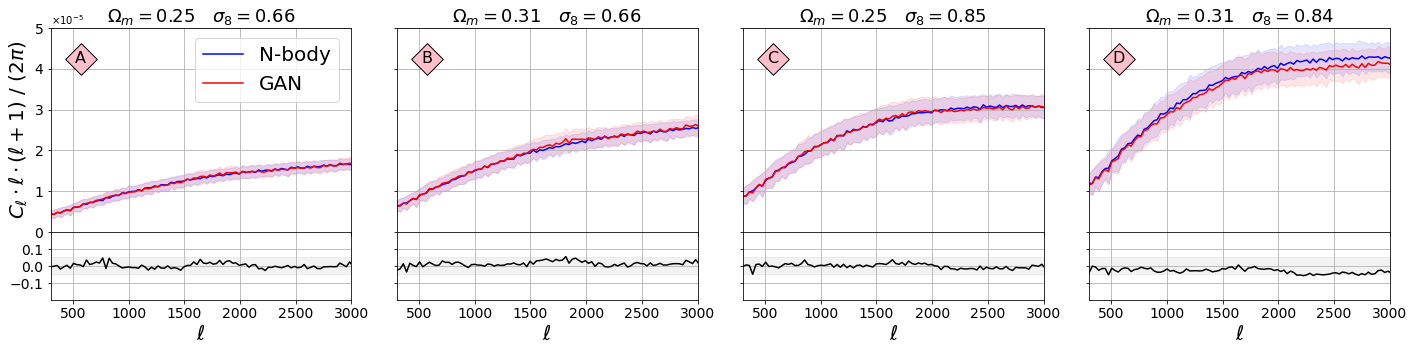

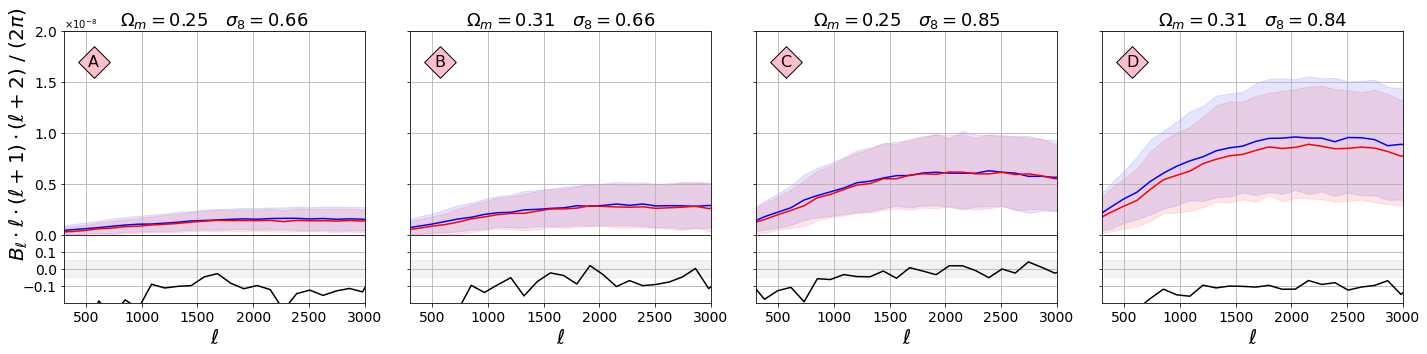

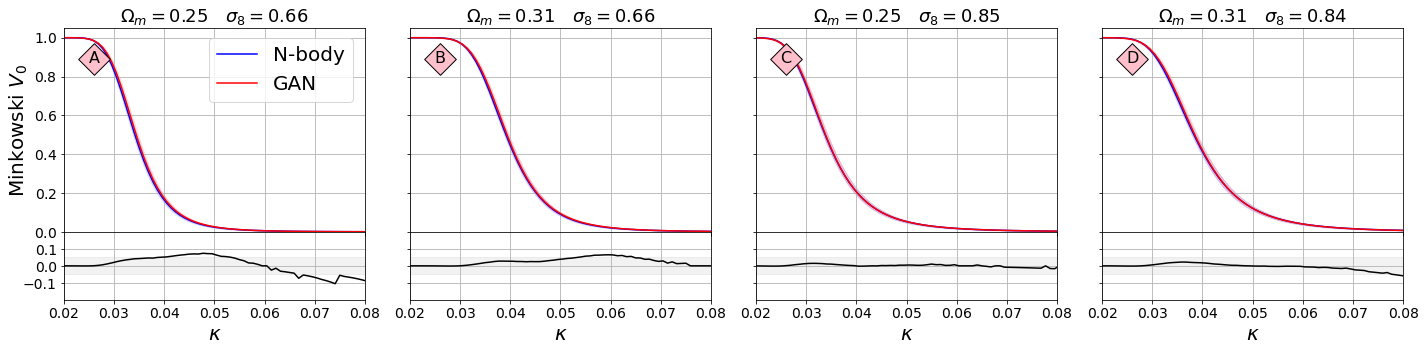

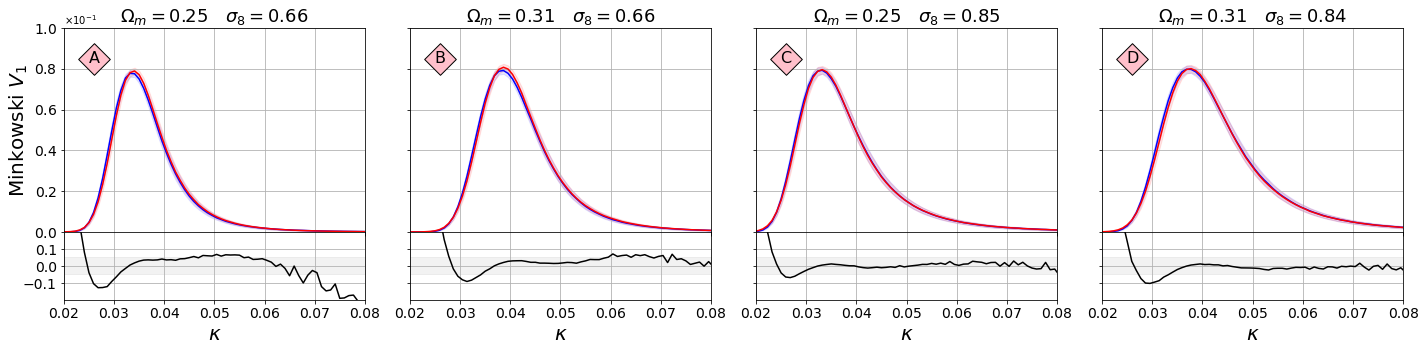

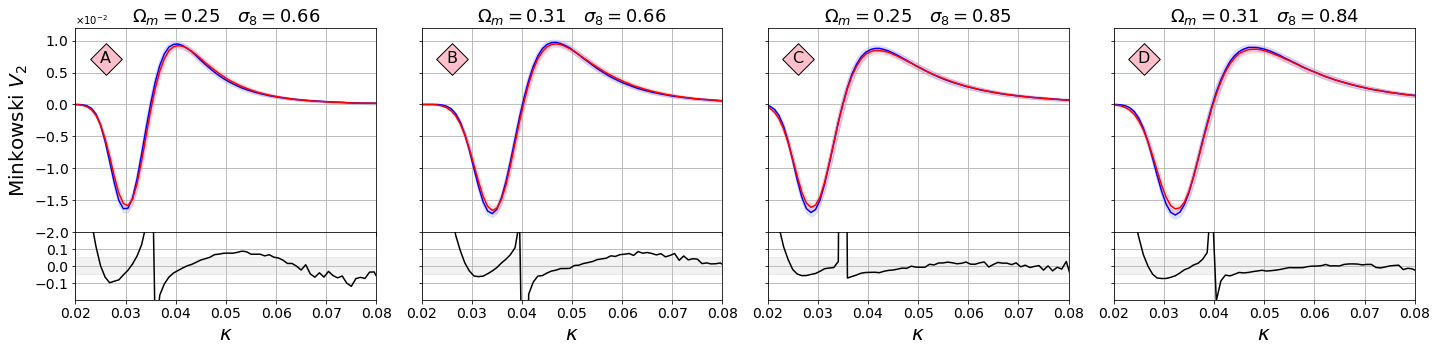

In [239]:
list_stat = ['mass_hist', 'peak_count']
for i, stat in enumerate(list_stat):
    fig = plot_multiple_statistic_with_ratio(ids=param_ids, stats=stats_interpolation, stats_name=stat, show_legend=i == 0)
    fig.savefig('figure_interpolated_{}.pdf'.format(stat), dpi=200)
list_stat = ['psd', 'bispectrum']
for i, stat in enumerate(list_stat):
    fig = plot_multiple_statistic_with_ratio(ids=param_ids, stats=stats_interpolation, stats_name=stat, show_legend=i == 0)
    fig.savefig('figure_interpolated_{}.pdf'.format(stat), dpi=200)
list_stat = ['minkowski_V0', 'minkowski_V1', 'minkowski_V2']
for i, stat in enumerate(list_stat):
    fig = plot_multiple_statistic_with_ratio(ids=param_ids, stats=stats_interpolation, stats_name=stat, show_legend=i == 0)
    fig.savefig('figure_interpolated_{}.pdf'.format(stat), dpi=200)

#  FIGURE grid train test

In [50]:
def plot_grid_train_test(test_params, train_params, labels=['$\Omega_m$', '$\sigma_8$'], params_text=None, kw_scatter={}):
        
    nx, ny = 1, 1; 
    fig, ax = plt.subplots(nx, ny, figsize=(ny * 6, nx * 5), sharey=True, sharex=True, squeeze=False, gridspec_kw={'hspace':0.1, 'wspace':0.1}); axc=ax[0,0]; axl=ax[0,:];
    s=axc.scatter(test_params[:, 0], test_params[:, 1], c=color_testset, marker='D', s=250, label='test set',  **kw_scatter)
    axc.scatter(train_params[:, 0], train_params[:, 1], c=color_trainset, marker='o', s=150, label='training set', **kw_scatter)
    axc.set_xlabel(labels[0], fontsize=fontsize_label)
    axc.set_ylabel(labels[1], fontsize=fontsize_label)
    axc.legend(fontsize=fontsize_legend)
    axc.set_title('simulation sets', fontsize=fontsize_title)
    axc.grid(True)
    axc.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    axc.set(xlim=lim_omega_m, ylim=lim_sigma_8)
    if params_text is not None:
        for i, p in enumerate(params_text):
            axc.text(p[0], p[1], params_highlight_labels[i], zorder=100, fontsize=fontsize_testset_letter, ha='center', va='center', color='k')
    fig.subplots_adjust(left=0.15)
    
    return fig

In [147]:
params_text=params_inter[param_ids]
fontsize_testset_letter = 11
print(params_text)
kw_scatter = dict(edgecolor='k', zorder=100)


[[0.25  0.658]
 [0.312 0.664]
 [0.254 0.852]
 [0.311 0.842]]


In [ ]:
fig = plot_grid_train_test(params_test, params_train, params_text=params_text, kw_scatter=kw_scatter)
fig.savefig('figure_grid_test_train.pdf', dpi=200, bbox_inches='tight')

# FIGURE grid accuracy

Fractional differences

In [595]:
def calculate_accuracy_frac_diff(stats, list_stat_name):
    
    avg = np.nanmean
    acc = {s: np.zeros(len(stats)) for s in list_stat_name}
        
    for j, stat_name in enumerate(list_stat_name):
        for i in range(len(stats)):
            x = stats[i][stat_name]['x']
            select = (x>stat_specs[stat_name]['xlim'][0]) & (x<stat_specs[stat_name]['xlim'][1])
            yf = avg(stats[i][stat_name]['y_fake'], axis=0)[select]
            yr = avg(stats[i][stat_name]['y_real'], axis=0)[select]
            diff = get_frac_diff(yf, yr)
#             diff = get_dynamic_range_difference2(yf, yr)
            acc[stat_name][i] = avg(np.abs(diff))
    return acc
        
    

In [596]:
stats_inter = read_pickle('compute_plots_for_params__interpolation.pkl')
stats_extra = read_pickle('compute_plots_for_params__extrapolation.pkl')
stats_train = read_pickle('compute_plots_for_params__trainset.pkl')

In [597]:
list_stats = ['psd', 'bispectrum', 'minkowski_V0', 'minkowski_V1', 'minkowski_V2']

In [598]:
accuracy_extra = calculate_accuracy_frac_diff(stats_extra, list_stats)
accuracy_inter = calculate_accuracy_frac_diff(stats_inter, list_stats)
accuracy_train = calculate_accuracy_frac_diff(stats_train, list_stats)
params_test = np.vstack([params_inter, params_extra])
accuracy_test = {s: np.concatenate([accuracy_inter[s], accuracy_extra[s]]) for s in list_stats}

Wasserstein distance for histograms

In [625]:
dict_mass1D_testset = read_pickle('mass_1D_tests__testset.pkl')
dict_mass1D_trainset = read_pickle('mass_1D_tests__trainset.pkl')
accuracy_test['wasserstein_mass_hist'] = dict_mass1D_testset['wass_pixel']
accuracy_train['wasserstein_mass_hist'] = dict_mass1D_trainset['wass_pixel']
accuracy_test['wasserstein_peak_count'] = dict_mass1D_testset['wass_peaks']
accuracy_train['wasserstein_peak_count'] = dict_mass1D_trainset['wass_peaks']

SSIM

In [603]:
def get_ssim_significance(s_fake_all, s_real_all):
    s_fake = s_fake_all.mean(axis=1)
    s_real = s_real_all.mean(axis=1)
    s_fake_std = s_fake_all.std(axis=1)#/np.sqrt(s_fake_all.shape[1])
    s_real_std = s_real_all.std(axis=1)#/np.sqrt(s_fake_all.shape[1])
#     sig = (s_fake-s_real)/np.sqrt(s_fake_std**2+s_real_std**2)
    sig = (s_fake-s_real)/((s_fake_std+s_real_std)/2)
    return sig

In [604]:
dict_ssim_trainset = read_pickle('dict_ssim_trainset.pkl')
dataset = load.load_params_dataset(filename=dataset_train_name, batch=N, sorted=True, shape=[ns, ns])
dict_ssim_trainset['params_cosmo'] = params_cosmo=dataset.get_different_params()

dict_ssim_testset = read_pickle('dict_ssim_testset.pkl')
dataset = load.load_params_dataset(filename=dataset_test_name, batch=N, sorted=True, shape=[ns, ns])
dict_ssim_testset['params_cosmo'] = params_cosmo=dataset.get_different_params()


In [605]:
sig_ssim_train = get_ssim_significance(dict_ssim_trainset['s_fake_all'], dict_ssim_trainset['s_real_all'])
sig_ssim_test = get_ssim_significance(dict_ssim_testset['s_fake_all'], dict_ssim_testset['s_real_all'])
accuracy_test['ssim_sig']=sig_ssim_test
accuracy_train['ssim_sig']=sig_ssim_train

Correlation


In [606]:
def get_fro_norm(list_corr):
    fro_norm = np.zeros(len(list_corr))
    for i, c in enumerate(list_corr):
        n=c.shape[0]
        fro_norm[i] = np.linalg.norm(c)
    return fro_norm

def get_matrix_difference(corr):
    mat_diff = np.zeros(len(corr['corrmat_fake']))
    from scipy.stats import median_abs_deviation
    for i, c in enumerate(corr['corrmat_fake']):
        n = corr['corrmat_fake'][i].shape[0]
        cfo = corr['corrmat_fake'][i][~np.eye(n).astype(np.bool)]
        cro = corr['corrmat_real'][i][~np.eye(n).astype(np.bool)]
        diff = (cfo-cro)/cro
        diff = diff[np.isfinite(diff)]
        mat_diff[i] = median_abs_deviation(diff.flatten())
    return mat_diff
    

In [607]:
dict_corr = read_pickle('corr_results.pkl')  

In [608]:
fro_fake_train = get_fro_norm(dict_corr['c_train']['corrmat_fake'])
fro_real_train = get_fro_norm(dict_corr['c_train']['corrmat_real'])
fro_fake_test = get_fro_norm(dict_corr['c_test']['corrmat_fake'])
fro_real_test = get_fro_norm(dict_corr['c_test']['corrmat_real'])
accuracy_test['corr_fro_norm']=np.abs(fro_fake_test-fro_real_test)/fro_real_test
accuracy_train['corr_fro_norm']=np.abs(fro_fake_train-fro_real_train)/fro_real_train
list_stats = ['corr_fro_norm', 'ssim_sig', 'psd', 'bispectrum']

In [609]:
accuracy_test['corr_diff']=get_matrix_difference(dict_corr['c_test'])
accuracy_train['corr_diff']=get_matrix_difference(dict_corr['c_train'])
list_stats = ['ssim_sig', 'psd', 'corr_diff', 'bispectrum']


Frechet Inception Distance

In [610]:
def wasserstein(mu1, mu2, sig1, sig2):
    from scipy.linalg import sqrtm
    w = np.linalg.norm(mu1 - mu2)**2 + np.linalg.norm(sqrtm(sig1)-sqrtm(sig2))**2
    n = len(mu1)
    w = w/n
    return w

In [611]:
def calcualte_fid(pred_params):
    w = np.zeros(pred_params.shape[0])
    for i in range(pred_params.shape[0]):
        pred_real = pred_params[i, 0, :, :] 
        pred_fake = pred_params[i, 1, :, :] 
        mean_pred_real = pred_real.mean(axis=0)
        stdv_pred_real = pred_real.std(axis=0)
        pred_real -= mean_pred_real
        pred_fake -= mean_pred_real
        pred_real /= stdv_pred_real
        pred_fake /= stdv_pred_real
#         print(pred_real.std(axis=0))
        mean_real, cov_real = np.mean(pred_real, axis=0), np.cov(pred_real.T)
        mean_fake, cov_fake = np.mean(pred_fake, axis=0), np.cov(pred_fake.T)
#         print(cov_real, cov_fake)
        wass = wasserstein(mu1=mean_real, mu2=mean_fake, sig1=cov_real, sig2=cov_fake)
        w[i] = np.sqrt(wass)
    return w

In [612]:
dict_regression = read_pickle('results_fid.pkl')
accuracy_test['fid'] = calcualte_fid(dict_regression['dict_pickle_test']['pred_params'])
accuracy_train['fid'] = calcualte_fid(dict_regression['dict_pickle_train']['pred_params'])

Display values for some scores

In [613]:
params_inter[param_ids]

array([[0.25 , 0.658],
       [0.312, 0.664],
       [0.254, 0.852],
       [0.311, 0.842]])

In [614]:
params_test

array([[0.137, 1.23 ],
       [0.25 , 0.658],
       [0.311, 0.842],
       [0.199, 0.87 ],
       [0.254, 0.852],
       [0.312, 0.664],
       [0.356, 0.614],
       [0.421, 0.628],
       [0.196, 1.225],
       [0.127, 0.836],
       [0.487, 0.643]])

In [615]:
list_params_show = [4,7,5,6]

In [616]:
for i, p in enumerate(list_params_show):
    print('param={} {:2.2f}'.format(params_highlight_labels[i], accuracy_test['corr_fro_norm'][p]))

param=A 0.02
param=B 0.14
param=C 0.06
param=D 0.06


In [617]:
for i, p in enumerate(list_params_show):
    print('param={} {:2.2f}'.format(params_highlight_labels[i], accuracy_test['ssim_sig'][p]))

param=A 0.08
param=B 0.23
param=C -0.27
param=D 0.42


In [624]:
for i, p in enumerate(list_params_show):
    print('param={} {:2.2f}'.format(params_highlight_labels[i], accuracy_test['wasserstein_mass_hist'][p]))

param=A 0.04
param=B 0.02
param=C 0.02
param=D 0.02


In [626]:
for i, p in enumerate(list_params_show):
    print('param={} {:2.2f}'.format(params_highlight_labels[i], accuracy_test['wasserstein_peak_count'][p]))

param=A 0.04
param=B 0.03
param=C 0.01
param=D 0.02


In [627]:
for i, p in enumerate(list_params_show):
    print('param={} {:2.2f}'.format(params_highlight_labels[i], accuracy_test['fid'][p]))

param=A 1.26
param=B 1.44
param=C 1.00
param=D 1.19


Plot combined figure

In [618]:
def plot_grid_accuracy(list_stats, test_scores, test_params, train_scores, train_params, thresholds=None, labels=['$\Omega_m$', '$\sigma_8$'], kw_scatter={}, gridspec_kw={'hspace':0.05, 'wspace':0.05}, layout=None):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    ns = len(list_stats)
    nx, ny = 1, ns+1; 
    if layout is None:
        nx, ny = 1, ns; 
    else:
        nx, ny = layout
    fig, ax = plt.subplots(nx, ny, figsize=(ny * 6, nx * 5), sharey=True, sharex=True, squeeze=False, gridspec_kw=gridspec_kw); axc=ax[0,0]; axl=ax[0,:];

    axf = ax.ravel()
    for i, stat in enumerate(list_stats):
        ss=stat_specs[stat]
        axf[i].grid(True)
        s=axf[i].scatter(test_params[:, 0], test_params[:, 1], c=test_scores[stat], marker='D', s=250, vmin=ss['difference_range'][0], vmax=ss['difference_range'][1], cmap=ss['cmap'], **kw_scatter)
        axf[i].scatter(train_params[:, 0], train_params[:, 1], c=train_scores[stat], marker='o', s=150, vmin=ss['difference_range'][0], vmax=ss['difference_range'][1], cmap=ss['cmap'], **kw_scatter)
        axf[i].set_xlabel(labels[0], fontsize=fontsize_label)
        if i ==0 or i==3:
            axf[i].set_ylabel(labels[1], fontsize=fontsize_label)
        cbaxes = inset_axes(axf[i], width="50%", height="7%", loc='upper right', borderpad=1.4) 
        fig.colorbar(s, orientation="horizontal", cax=cbaxes)
        cbaxes.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
        axf[i].set_title(ss['difference_title'], fontsize=fontsize_title)
        axf[i].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
        axf[i].set(xlim=lim_omega_m, ylim=lim_sigma_8)
    return fig

In [619]:
kw_scatter = dict(cmap=plt.cm.Spectral_r, edgecolor='k', vmin=0, vmax=None, zorder=100)
fontsize_label=20
fontsize_legend=16
fontsize_title=19
fontsize_ticks=16
lim_omega_m=[0.08, 0.52]
lim_sigma_8=[0.4, 1.4]

In [620]:
list_stats = ['ssim_sig',  'fid', 'wasserstein_mass_hist', 'psd', 'corr_fro_norm', 'bispectrum']
kw_scatter = dict(edgecolor='k', zorder=100)
stat_specs['fid']['difference_range']  = [0,5] 


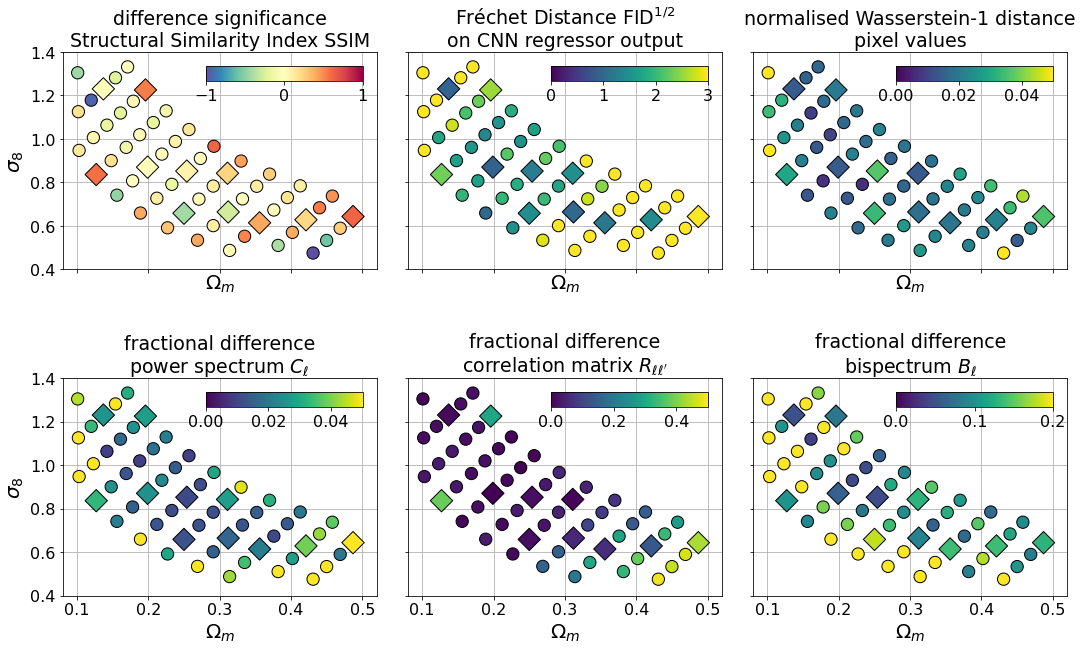

In [623]:
fig = plot_grid_accuracy(list_stats, accuracy_test, params_test, accuracy_train, params_train, kw_scatter=kw_scatter, layout=[2,3], gridspec_kw={'hspace':0.5, 'wspace':0.1})
fig.savefig('figure_grid_diff.pdf', dpi=200, bbox_inches='tight')

# FIGURE correlation matrices

In [123]:
def corr_combine(c1, c2):
    return np.tril(c1)+np.triu(c2) - np.eye(c1.shape[0])

In [132]:
def plot_matrices_for_params(params, dict_corr, kw_pcolor):

    nx, ny = 1, len(params); 
    fig, ax = plt.subplots(nx, ny, figsize=(ny * 6, nx * 6),  sharex=True, sharey=True, squeeze=False, gridspec_kw={'wspace':0.05}); axc=ax[0,0]; axl=ax[0,:];
    for i in range(ny):
        c_comb = corr_combine(dict_corr['corrmat_real'][i], dict_corr['corrmat_fake'][i])
        s=ax[0,i].pcolormesh(l_edges, l_edges, c_comb, **kw_pcolor)
        if i==0:
            ax[0,i].set_ylabel(r'$\ell$', fontsize=fontsize_label)
        ax[0,i].set_xlabel(r'$\ell$', fontsize=fontsize_label)
        pos_x = cut_corr[0] + (cut_corr[1]-cut_corr[0])*0.2
        pos_y = cut_corr[0] + (cut_corr[1]-cut_corr[0])*0.85
        ax[0,i].text(pos_x, pos_y, 'N-body', zorder=201, fontsize=fontsize_tag, ha='left', va='bottom', color='w')

        pos_x = cut_corr[0] + (cut_corr[1]-cut_corr[0])*0.7
        pos_y = cut_corr[0] + (cut_corr[1]-cut_corr[0])*0.07
        ax[0,i].text(pos_x, pos_y, 'GAN', zorder=201, fontsize=fontsize_tag, ha='left', va='bottom', color='w')
            
        pos_x = cut_corr[0] + (cut_corr[1]-cut_corr[0])*0.1
        pos_y = cut_corr[0] + (cut_corr[1]-cut_corr[0])*0.9
        ax[0,i].scatter(pos_x, pos_y, marker='D', s=markersize_testset*2, c=color_testset, edgecolor='k', zorder=200)
        ax[0,i].text(pos_x, pos_y, params_highlight_labels[i], zorder=201, fontsize=16, ha='center', va='center', color='k')
        ax[0,i].tick_params(axis='both', labelsize=fontsize_ticks)
        
        ax[0,i].plot(l_edges, l_edges, c='k', lw=linewidth_diag)

    # [left, bottom, width, height] 
    cbaxes = fig.add_axes([0.91, 0.2, 0.01, 0.6]) 
    fig.colorbar(s, orientation="vertical", cax=cbaxes)
    cbaxes.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    return fig

In [125]:
dict_corr = read_pickle('corr_results.pkl')  
dict_corr['cut_corr'] = [300,3000] # remove after rerun
dict_corr['bin_k'] = 20 # remove after rerun
cut_corr = dict_corr['cut_corr']
bin_k = dict_corr['bin_k']
l_edges = np.linspace(dict_corr['cut_corr'][0], dict_corr['cut_corr'][1], dict_corr['bin_k'])
fontsize_label=18
fontsize_tag=32
fontsize_ticks=14
linewidth_diag=1
N=2000

In [131]:
dict_corr['c_train'].keys()

dict_keys(['covmat_real', 'covmat_fake', 'corrmat_real', 'corrmat_fake'])

In [133]:
dataset = load.load_params_dataset(filename=dataset_train_name, batch=N, sorted=True, shape=[ns, ns])
params_train = dataset.get_different_params()
dataset = load.load_params_dataset(filename=dataset_test_name, batch=N, sorted=True, shape=[ns, ns])
params_test = dataset.get_different_params()
kw_pcolor = {'cmap':plt.cm.viridis, 'vmin':0.4, 'vmax':1, 'rasterized':True}

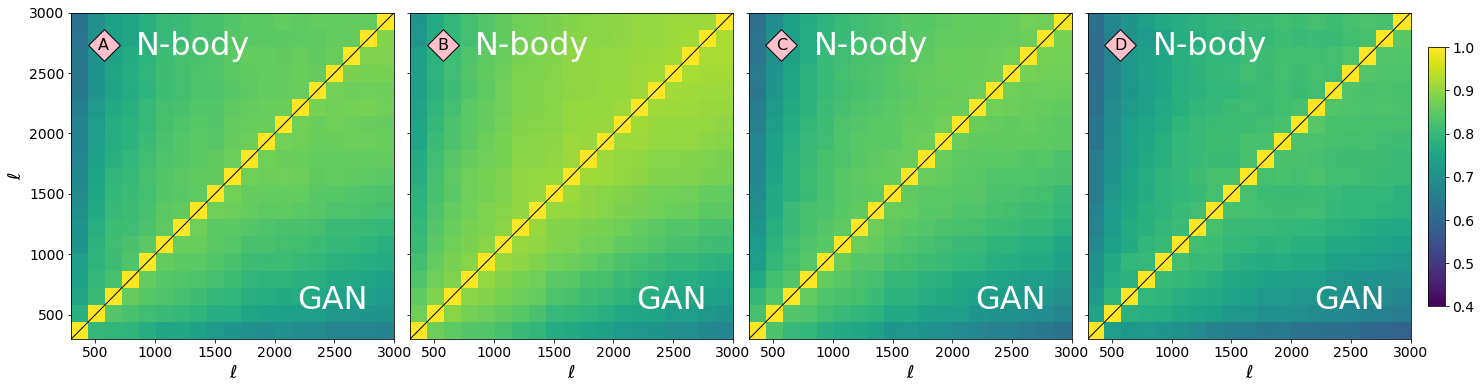

In [134]:
fig = plot_matrices_for_params(params=params_inter[param_ids], dict_corr=dict_corr['c_test'], kw_pcolor=kw_pcolor)
fig.savefig('figure_corrmat.pdf', dpi=200, bbox_inches='tight')

# FIGURE regressor

In [101]:
def get_frechet_results_for_dataset(dataset_name, N=2000):
    dataset = load.load_params_dataset(filename=dataset_name, batch=N, sorted=True, shape=[ns, ns])
        # Define parameters
    params = dataset.get_different_params()
    params = np.array(params)
    # Generate images
    real_imgs = []
    fake_imgs = []
    for i, p in enumerate(params):
        printt('param {}/{}'.format(i, len(params)))
        real_imgs.append(dataset.get_data_for_params(p, N=N)[0])
        fake_imgs.append(evaluation.generate_samples_params(wgan, p, nsamples=N, checkpoint=checkpoint))

    fids, fig, pred_params, params, features = evaluation.compute_plot_fid(real_imgs, fake_imgs, params, regressor_path, batch_size=N, checkpoint=140000, lims=[[0.05, 0.5], [0.4, 1.4]], alpha=0.025)
    plt.close(fig)
    dict_pickle = dict(fids=fids, pred_params=pred_params, params=params, features=features)
    return dict_pickle

In [102]:
# Load regressor
regressor_path = '../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/'
N = 500

In [103]:
wgan = GANsystem(CosmoConditionalParamWGAN, params)
dict_pickle_test = get_frechet_results_for_dataset(dataset_name=dataset_test_name, N=N)
wgan = GANsystem(CosmoConditionalParamWGAN, params)
dict_pickle_train = get_frechet_results_for_dataset(dataset_name=dataset_train_name, N=N)
dict_pickle_full = dict(dict_pickle_train=dict_pickle_train, dict_pickle_test=dict_pickle_test, N=N)
write_pickle('results_fid.pkl', dict_pickle_full)

Generator 
--------------------------------------------------
     The input is of size (?, 128)
     0 Full layer with 256 outputs
         Size of the variables: (?, 256)
     1 Full layer with 512 outputs
         Size of the variables: (?, 512)
     2 Full layer with 32768 outputs
         Size of the variables: (?, 32768)
     Reshape to (?, 8, 8, 512)
     3 Deconv layer with 256 channels
         Non linearity applied
         Size of the variables: (?, 16, 16, 256)
     4 Deconv layer with 128 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 128)
     5 Deconv layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 64, 64, 64)
     6 Deconv layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 128, 128, 32)
     7 Deconv layer with 1 channels
         Size of the variables: (?, 128, 128, 1)
    Costum non linearity: <function non_lin at 0x7fd329f30f28>
     The output is of 

INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 1/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 2/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 3/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 4/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_W

Model loaded.
params 9/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
params 10/11 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
computing FIDGenerator 
--------------------------------------------------
     The input is of size (?, 128)
     0 Full layer with 256 outputs
         Size of the variables: (?, 256)
     1 Full layer wit

param 0/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 1/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 2/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 3/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 4/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_sma

Checkpoint succesfully loaded!
param 38/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 39/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 40/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 41/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/KidsConditional128_smart_2D_checkpoints/Conditional_Params_WGAN-349163
Checkpoint succesfully loaded!
param 42/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/

Model loaded.
params 11/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
params 12/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
params 13/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] 

params 32/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
params 33/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
params 34/46 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../../upscaleGAN/saved_results/Regressor/Kids_Regressor_128_smart_2D_mac_checkpoints/Regressor-140000
Model loaded.
 [*] Reading checkp

Make plot

In [104]:
def plot_regressor_contours(params, pred_params):
    from plotting.triangle_marginals import contour_cl
    npar = len(params)
    nx, ny = 1, 1; fig, ax = plt.subplots(nx, ny, figsize=(ny * 6, nx * 4), squeeze=False, gridspec_kw={'wspace':0.0, 'hspace':0.0}); axc=ax[0,0]; axl=ax[0,:];
    i=0
    dict_ranges={'omega_m':lim_omega_m, 'sigma_8':lim_sigma_8}
    columns=['omega_m', 'sigma_8']
    kde_kwargs = {'n_points':50}
    kw_contourf = {'alpha':0.05}
    for i in range(npar):

            dp = {'omega_m':pred_params[i, 0, :, 0], 'sigma_8':pred_params[i, 0, :, 1]}
            contour_cl(axc, data=dp, ranges=dict_ranges, columns=columns, i=1, j=0, fill=True, color='b', kde_kwargs=kde_kwargs, kw_contourf=kw_contourf)
            dp = {'omega_m':pred_params[i, 1, :, 0], 'sigma_8':pred_params[i, 1, :, 1]}
            contour_cl(axc, data=dp, ranges=dict_ranges, columns=columns, i=1, j=0, fill=True, color='r', kde_kwargs=kde_kwargs, kw_contourf=kw_contourf)
            axc.scatter(params[i,0], params[i,1], marker='*', s=200, c='k')

    axc.grid(True)
    axc.set(xlim=lim_omega_m, ylim=lim_sigma_8)
    axc.set_ylabel(r'$\sigma_8$', fontsize=fontsize_label)
    axc.set_xlabel(r'$\Omega_m$', fontsize=fontsize_label)
    return fig 

In [106]:
def calcualte_fid(pred_params):
    w = np.zeros(pred_params.shape[0])
    for i in range(pred_params.shape[0]):
        pred_real = pred_params[i, 0, :, :] 
        pred_fake = pred_params[i, 1, :, :] 
        mean_real, cov_real = np.mean(pred_real, axis=0), np.cov(pred_real.T)
        mean_fake, cov_fake = np.mean(pred_fake, axis=0), np.cov(pred_fake.T)
        print(cov_real, cov_fake)
        w[i] = wasserstein(mu1=mean_real, mu2=mean_fake, sig1=cov_real, sig2=cov_fake)
    return w

In [107]:
dict_regression = read_pickle('results_fid.pkl')
params_pred_all = np.concatenate([dict_regression['dict_pickle_train']['pred_params'], dict_regression['dict_pickle_test']['pred_params']])
params_all =np.concatenate([dict_regression['dict_pickle_train']['params'], dict_regression['dict_pickle_test']['params']])

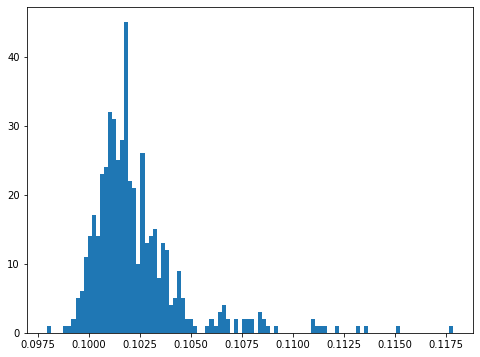

In [113]:
nx, ny = 1, 1; fig, ax = plt.subplots(nx, ny, figsize=(ny * 8, nx * 6), squeeze=False); axc=ax[0,0]; axl=ax[0,:];
axc.hist(dict_regression['dict_pickle_train']['pred_params'][1,0,:,0], bins=100);

In [111]:
alpha=0.1
lim_omega_m=[0.08, 0.52]
lim_sigma_8=[0.4, 1.4]
fontsize_label=16
kw_scatter = {'alpha':0.1, 's':10}

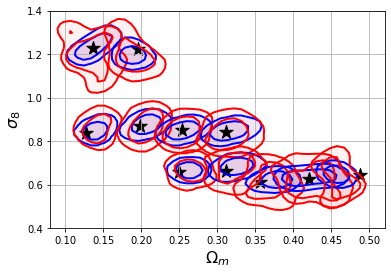

In [112]:
fig = plot_regressor_contours(dict_regression['dict_pickle_test']['params'], dict_regression['dict_pickle_test']['pred_params']);
fig.savefig('figure_regression.pdf', bbox_inches='tight')

In [115]:
calcualte_fid(dict_regression['dict_pickle_train']['pred_params'])

[[2.10404439e-06 9.06659120e-07]
 [9.06659120e-07 8.56598933e-05]] [[ 7.84918388e-05 -1.94254040e-04]
 [-1.94254040e-04  2.23150676e-03]]
[[5.49867022e-06 1.25525086e-05]
 [1.25525086e-05 6.07886150e-05]] [[ 5.96413440e-05 -1.64610262e-04]
 [-1.64610262e-04  3.97595255e-03]]
[[2.76483583e-06 3.91003671e-06]
 [3.91003671e-06 2.70364205e-05]] [[ 3.78608921e-05 -3.40144607e-05]
 [-3.40144607e-05  4.48887495e-04]]
[[1.95515864e-05 4.78177894e-05]
 [4.78177894e-05 1.64562111e-04]] [[ 0.0001355  -0.00033993]
 [-0.00033993  0.00402799]]
[[2.23502804e-05 5.67292151e-05]
 [5.67292151e-05 1.76909837e-04]] [[1.12953642e-04 4.86888032e-05]
 [4.86888032e-05 1.22193563e-03]]
[[1.37996613e-05 3.65994971e-05]
 [3.65994971e-05 1.43733655e-04]] [[ 1.08717891e-04 -3.61305279e-05]
 [-3.61305279e-05  2.01668665e-03]]
[[1.18900250e-05 5.46217154e-06]
 [5.46217154e-06 6.92567515e-05]] [[ 3.94785795e-05 -4.59515141e-05]
 [-4.59515141e-05  6.95574267e-04]]
[[1.81992621e-05 5.19848300e-05]
 [5.19848300e-05 2.09

array([2.07250160e-03, 3.13831995e-03, 2.84895349e-04, 3.00430740e-03,
       6.88211661e-04, 1.52062751e-03, 3.41076461e-04, 4.97325234e-03,
       1.90688450e-04, 1.69612385e-03, 8.11404873e-04, 4.18526025e-03,
       3.23685127e-04, 1.76630975e-03, 7.67076903e-04, 8.64399148e-05,
       1.21159006e-03, 3.42467638e-04, 8.10387894e-04, 1.32109152e-03,
       9.64611812e-05, 4.06304852e-04, 8.53180366e-04, 1.22778132e-03,
       2.69110531e-04, 2.92173001e-04, 1.13664152e-03, 9.05169796e-04,
       4.63150700e-04, 1.23813220e-03, 4.19616870e-04, 1.56568795e-03,
       4.83844346e-04, 1.08995873e-03, 9.16025319e-04, 1.68036567e-03,
       1.78316158e-03, 7.11468664e-04, 1.56019735e-03, 1.50277268e-03,
       1.41796999e-03, 2.72316578e-03, 3.26588134e-03, 1.05372679e-03,
       2.60762354e-03, 2.05689907e-03])